In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
#from scipy import special
import scipy.optimize as so
from sympy import *


In [2]:
from functions_Data_assim import *


## CREATION OF OBSERVATION FILES 

i am inventig an array of observations, representing measurements of temperature in the soil at 5 cm and 10 cm depth. Then i used something to sample it at the wanted frequency, for the data assimilation part i will try to observe which frequency of observation gives enough information to correct the model and give an appropriate solution. 

In [64]:
 #parameters 
limt=24*10  #10 days in hours 
dt=1/60  #dt 1 minute
tt=np.arange(0,limt,dt)
freq=60*3  # 1h in minutes 

limx=100
dx=1
xx=np.arange(0,limx,dx)

Nt=len(tt)
Nx=len(xx)

s=5  #standard dev   gaussian
mu=0   #gaussian mean
K=0.6  #thermal conductivity of soil

In [65]:
#measurements, truth of temperature and time of the measurements 
mes_5cm, true_5cm, tt_obs_5cm= obs_5(dt,limt,freq)

mes_10cm, true_10cm, tt_obs_10cm= obs_10(dt,limt,freq)

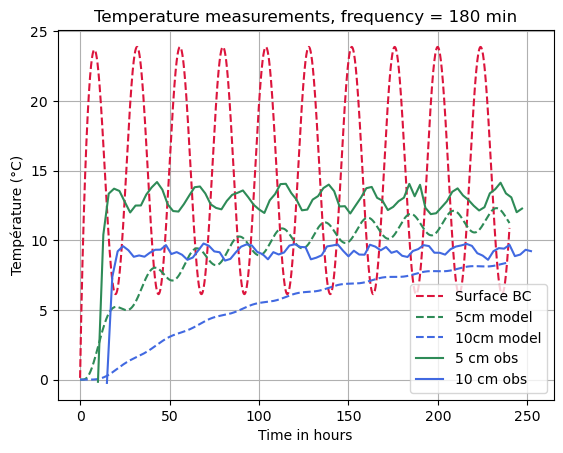

In [66]:
Tf=euler_f_BC_periodic(dx,dt,limx,limt,K)


plt.plot(tt,Tf[:,0],label='Surface BC',color='crimson',linestyle='--')
plt.plot(tt,Tf[:,5],label='5cm model',color='seagreen',linestyle='--')
plt.plot(tt,Tf[:,10],label='10cm model',color='royalblue',linestyle='--')

plt.plot(tt_obs_5cm, mes_5cm,label='5 cm obs',color='seagreen')
plt.plot(tt_obs_10cm, mes_10cm,label='10 cm obs',color='royalblue')

plt.title('Temperature measurements, frequency = '+ str(freq)+' min')
plt.xlabel('Time in hours')
plt.ylabel('Température (°C)')
plt.legend()
plt.grid()
plt.savefig('Obs+modelBC.png',dpi=300)

## DATA ASSIMILATION - 3D VAR


In [104]:
### parameters for 3DVAR

## Type and timing of observations
nvarobs = [5,10]            ## observed variables   mesure à 10,  et 5 cm 
nobs = len(nvarobs)
assim_steps =tt_obs_10cm   #assimilation steps depending on the frequency stated before

nassim = len(assim_steps)

#_______________________________________________
## Observation operator
hobs = np.zeros((nobs,len(xx)))
j=0
for i in range(nobs):
    hobs[j,nvarobs[i]] = 1 #binairy 1 when there is an obs and 0 when no obs
    j += 1

#_____________________________________________________________
#observations: temperature measurements
yobs5=mes_5cm
yobs10=mes_10cm
#observation covariance matrix
noisestd = 2.85
Robs= noisestd**2
#________________________________________

#covariance matrix of the errors on the background 
#less and less precise the deeper it is 

xstd = 4
#Pmat = np.eye(Nt)/(xstd**2)
Pmat=np.linspace(16,2,len(xx))   #diagonal terms only
#B = np.eye(3)/(xstd**2)

#____________________________________________________________________________________________



In [105]:
#euler forward scheme gives prevision of temperature in depth for the next time step using state vector x
def euler_f_assim(x,dt,dx,K,it):
    #it = number of the timestep where we want the simulation to start       
    Tz=np.zeros(len(x))
    #x # temperature vector in depth for a given time 
    x[0]=temp_cycle(tt,dt)[it]
    for j in range(1,len(x)-1):
        
        Tz[j]=x[j]+(K*dt/(dx**2))*(x[j+1]+x[j-1]-2*x[j])
    Tz[-1]=Tz[-2]   
    return Tz #propagates for the next time step using finite difference scheme 




## Kalman filtering 


## 3DVAR

In [111]:
xb_save = np.zeros((Nt,Nx))   # stocke résultats du modèle d'origine 
x_save = np.zeros((Nt,Nx))   #stocke résultats du modèle avec assimilation de données 
x_save[0,:] = gauss(xx, mu, s)
xb_save[:,0]=temp_cycle(tt,dt)# valeur au pas de temps 0   #backgroud
#Var_save = np.zeros((Nt+1,Nx))  #valeur de la variance 
#Var_save[0,:] = Pmat

xb=xb_save[0,:]
for it in range(Nt-1):

#FORECAST
    #Temperature field at each given time 
    xb=euler_f_assim(xb,dt,dx,K,it)# forecast at t+1 by running the model
    
#ANALYSIS    
    iobs=0
    if it in tt_obs_10cm:
         
        iit = np.argwhere(tt_obs_10cm==it)[0][0]
        yo = np.array([yobs5[iit], yobs10[iit]])
        
        #xa, pmat = blue( xb, Pmat, yo, Robs, Hobs ) #KALMAN FILTER 
        
        res = so.minimize(CostFunction,xb,args=(xb,yo,Pmat,Robs,hobs),  # minimize pour le paramètre xin  avec Cost function 3D VAR
                   method='Powell',options={'maxiter': 30})
        xb=res['x']
        iobs=+1
        
    x_save[it+1,:] = xb
       

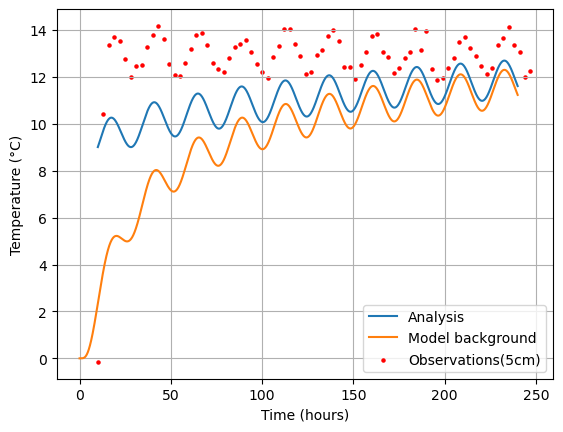

In [112]:
plt.plot(tt[10*60:Nt],x_save[10*60:Nt,5],label='Analysis')
plt.scatter(tt_obs_5cm,mes_5cm,marker='o',s=5,color='r',label='Observations(5cm)')
plt.plot(tt,Tf[:,5],label='Model background')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.grid()
#plt.savefig('3DVAR freq 3h 5cm.png',dpi=300)

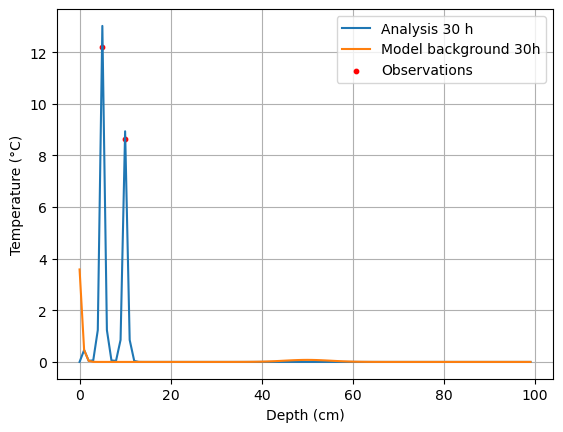

In [113]:

plt.plot(xx,x_save[30,:],label='Analysis 30 h')

plt.plot(xx,Tf[30,::],label='Model background 30h')
plt.scatter(10,mes_10cm[30],marker='o',s=10,color='r',label='Observations')
plt.scatter(5,mes_5cm[30],marker='o',s=10,color='r')
plt.legend()
plt.xlabel('Depth (cm)')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.savefig('3Dvartest.png',dpi=300)